In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification
! unzip gtzan-dataset-music-genre-classification
!apt install ffmpeg

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# **MAIN** **WORK**

In [133]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display    
import numpy as np
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

In [139]:
path = "Data/genres_original"
sample_rate = 22050
duration = 30
hop_length = 512
n_fft = 2048
n_mfcc = 13
samples_per_track = sample_rate*duration

In [140]:
def save_mfcc(dataset_path, n_mfcc=13, n_fft=2048, hop_length=512, n_segments=5):
    data = {
        "genre": [],
        "labels": [],
        "mfcc": []
    }

    sps = int(sample_rate / n_segments)
    nsps = np.ceil(sps / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:

            genre = dirpath.split("/")[-1]
            data["genre"].append(genre)
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                try:
                  spectrum, sr = librosa.load(file_path, sr=sample_rate)
                except:
                  pass

                for j in range(n_segments):
                    s = sps * j
                    e = s + sps
                    mfcc = librosa.feature.mfcc(spectrum[s:e], sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length).T

                    if len(mfcc) == nsps:
                        data["mfcc"].append(mfcc)
                        data["labels"].append(i-1)
    return data

In [141]:
data = save_mfcc(path, n_segments=10)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [142]:
genre_list = []
unique, counts = np.unique(np.array(data["labels"]), return_counts=True)
for i in data["genre"]:
  genre_list.append(i)

In [143]:
def io_split(data):
  input = np.array(data["mfcc"])
  output = np.array(data["labels"])
  return input, output

In [144]:
def train_test_splitting(x,y):
  return train_test_split(x,y, test_size=0.3)

In [145]:
x,y = io_split(data)
x_train, x_test, y_train, y_test = train_test_splitting(x,y)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7000, 5, 13)
(7000,)
(3000, 5, 13)
(3000,)


In [168]:
def plot_loss(history, activation = "relu"):
  iter_arr = np.arange(1,len(history["loss"])+1)
  plt.plot(iter_arr, history["loss"], 'b', label = "training")
  plt.plot(iter_arr, history["val_loss"], 'g', label = "testing")
  plt.ylabel("Loss")
  plt.title(str(activation) + " loss")
  plt.legend()
  plt.rcParams["figure.figsize"] = (8,6)
  plt.show()

def plot_accuracy(history, activation = "relu"):
  iter_arr = np.arange(1,len(history["accuracy"])+1)
  plt.plot(iter_arr, history["accuracy"], 'b', label = "training")
  plt.plot(iter_arr, history["val_accuracy"], 'g', label = "testing")
  plt.ylabel("Accuracy")
  plt.title(str(activation) + " accuracy")
  plt.legend()
  # plt.rcParams["figure.figsize"] = (8,6)
  plt.show()

In [152]:
def implements(x,y,xt,yt,activation_h = "relu", activation_o = "softmax",n_hidden = 3, n_neurons = [512, 256, 64], 
               learning_rate = 0.0001, epochs = 100, batch_size = 32, regularize = False, alpha = 0.001, dropout = False, dropout_prob = 0.3):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(x.shape[1], x.shape[2])))
  for i in range(n_hidden):
    if regularize:
      model.add(keras.layers.Dense(n_neurons[i], activation=activation_h, kernel_regularizer=keras.regularizers.l2(0.0001)))
    else:
      model.add(keras.layers.Dense(n_neurons[i], activation=activation_h))

    if dropout:
      model.add(keras.layers.Dropout(0.3))

  model.add(keras.layers.Dense(10, activation=activation_o))
  optimiser = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model.fit(x, y, validation_data=(xt, yt), batch_size=batch_size, epochs=epochs, verbose=0)

In [153]:
history = implements(x_train, y_train, x_test,y_test)

In [154]:
training_accuracy = history.history["accuracy"][-1]
testing_accuracy = history.history["val_accuracy"][-1]
print(training_accuracy)
print(testing_accuracy)

0.9901428818702698
0.546999990940094


In [155]:
# plot_loss(history)
# plot_accuracy(history)

In [157]:
activation_list = ["relu", "sigmoid", "tanh", "softplus"]
hidden_layer_list = [2,3,4]
hidden_layer_list_neurons = [[512,256], [512,256,64], [512,256,64,32]]
learning_rate = [0.01, 0.001, 0.0001, 0.00001]
alpha = [0.01,0.001,0.0001]
dropout_prob = [0.1,0.2,0.3]

# Analysis for the best model

## Finding the best activation
learning rate = 0.0001 <br>
no. of hidden layers = 3; neurons in each = [512,256,64] <br>
activation of output layer is fixed to be softmax
epochs = 100

In [172]:
def metrics(history_list, activation_list):
  for i in range(len(history_list)):
    print(str(activation_list[i]) + ": ")
    print("Training accuracy : ", history_list[i]["accuracy"][-1])
    print("Testing accuracy : ", history_list[i]["val_accuracy"][-1])
    plot_accuracy(history_list[i],activation=activation_list[i])
    plot_loss(history_list[i],activation=activation_list[i])


In [162]:
history_list = []
for i in activation_list:
  history = implements(x_train, y_train, x_test,y_test, activation_h=i)
  history_list.append(history.history)

relu: 
Training accuracy :  0.9887142777442932
Testing accuracy :  0.5206666588783264


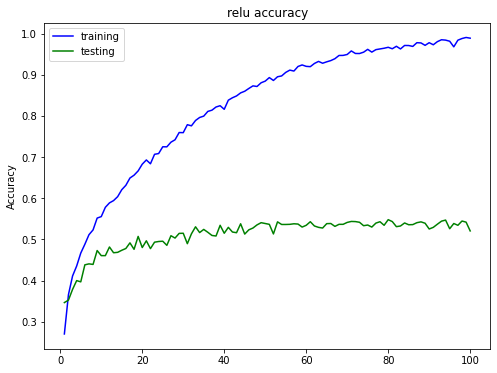

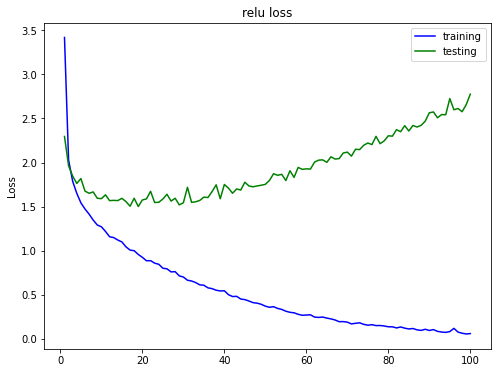

sigmoid: 
Training accuracy :  0.941428542137146
Testing accuracy :  0.4970000088214874


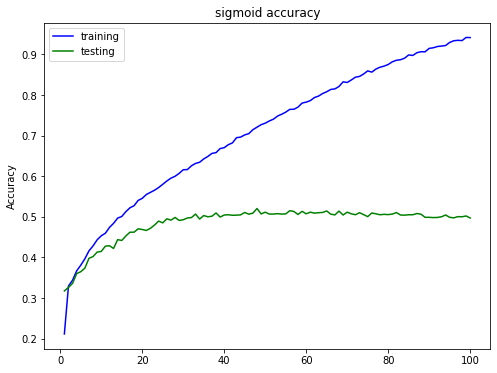

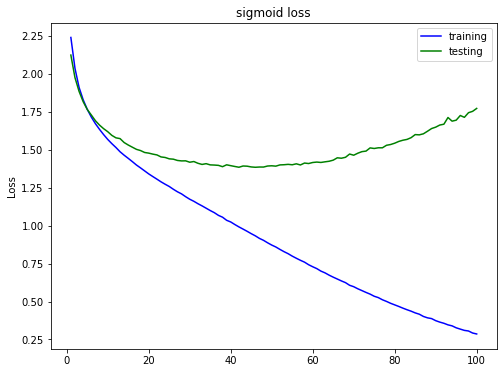

tanh: 
Training accuracy :  0.9997143149375916
Testing accuracy :  0.49266666173934937


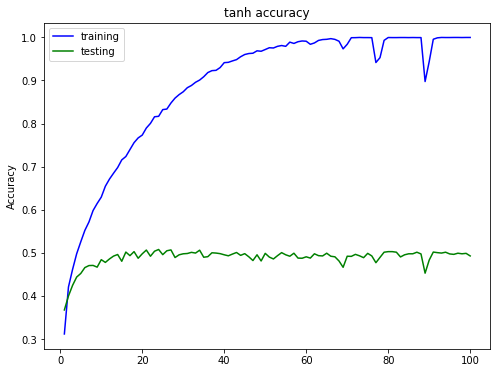

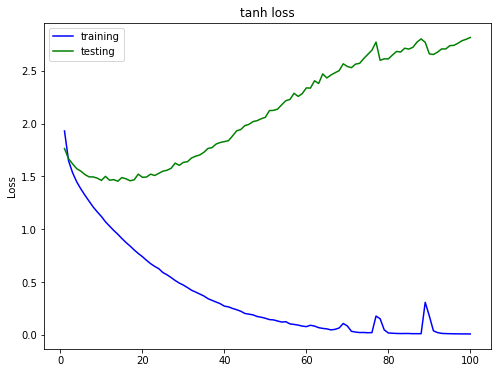

softplus: 
Training accuracy :  0.9991428852081299
Testing accuracy :  0.5583333373069763


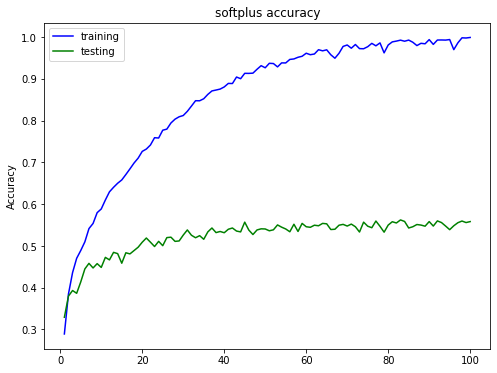

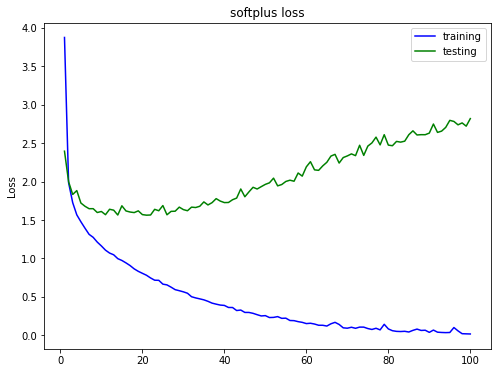

In [169]:
metrics(history_list,activation_list)

Upon looking the graph, we can conclude a very high variance in testing and training accuracy and so we know that our model is overfitting. In fact the testing loss starts to increase which indicates a high cross entropy loss. This will be dealt later. For now we see that softplus, relu and sigmoid, all 3 have performed similar on training and testing set thus we will go with softplus since it provides a little less variance than others.

## Finding the best learning rate
activation = softmax <br>
no. of hidden layers = 3; neurons in each = [512,256,64] <br>
activation of output layer is fixed to be softmax
epochs = 100

In [170]:
history_list = []
for i in learning_rate:
  history = implements(x_train, y_train, x_test,y_test, activation_h="softplus", learning_rate=i)
  history_list.append(history.history)

0.01: 
Training accuracy :  0.4044285714626312
Testing accuracy :  0.335999995470047


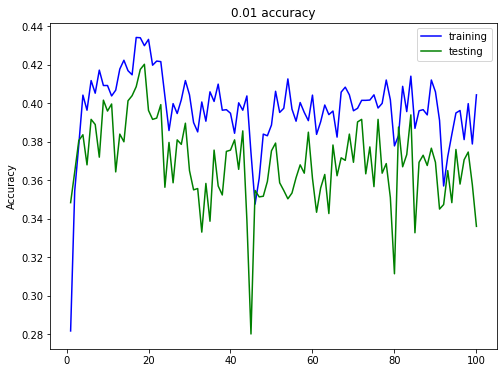

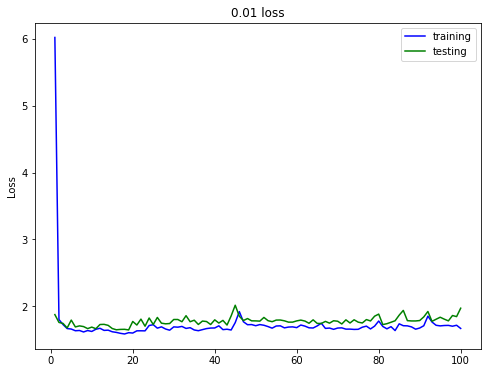

0.001: 
Training accuracy :  0.9888571500778198
Testing accuracy :  0.5666666626930237


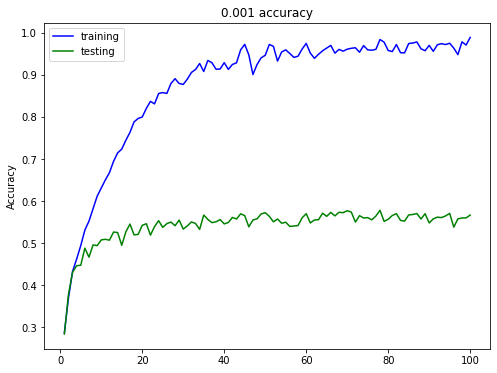

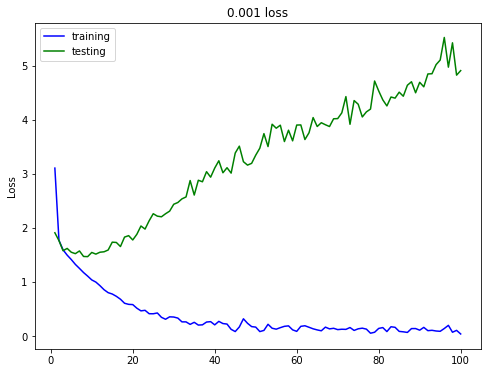

0.0001: 
Training accuracy :  0.9684285521507263
Testing accuracy :  0.5513333082199097


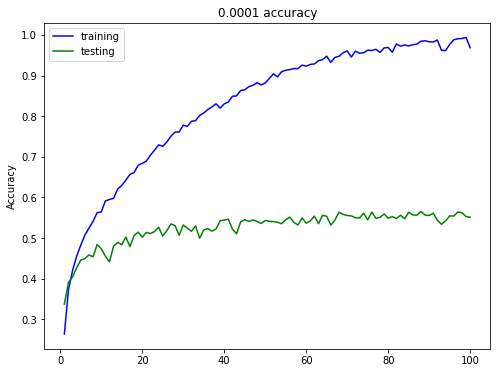

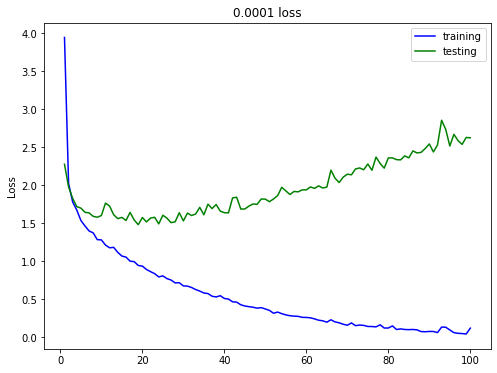

1e-05: 
Training accuracy :  0.7134285569190979
Testing accuracy :  0.49966666102409363


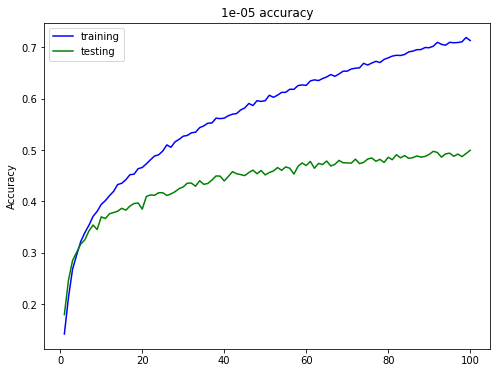

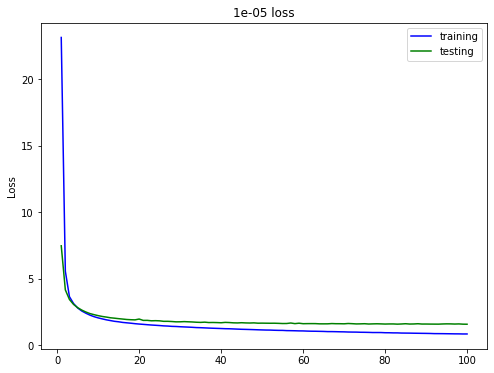

In [173]:
metrics(history_list, learning_rate)

From the above graphs we see that 0.01 definitely results in over convergence and bounces as reflective from the accuracy graph. 0.001 has a very high variance and loss increases margianally with low acuracy so it isn't appropriate as well. <br>

The best choice for alpha is either 0.0001 or 0.00001. <br> 0.00001 has a relatively low variance and loss converges quickly with epochs but accuracy on training and testing set is pretty low. <br> 0.0001 has a better performance but variance is very high

## Finding on number of layers
activation = softmax <br>
learning rate = 0.0001 <br>
activation of output layer is fixed to be softmax
epochs = 100

In [174]:
history_list = []
for i in range(len(hidden_layer_list)):
  history = implements(x_train, y_train, x_test,y_test, activation_h="softplus", learning_rate=0.0001, n_hidden=hidden_layer_list[i], n_neurons=hidden_layer_list_neurons[i])
  history_list.append(history.history)

2: 
Training accuracy :  0.9782857298851013
Testing accuracy :  0.5383333563804626


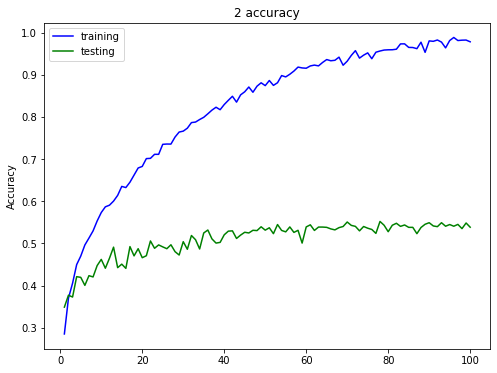

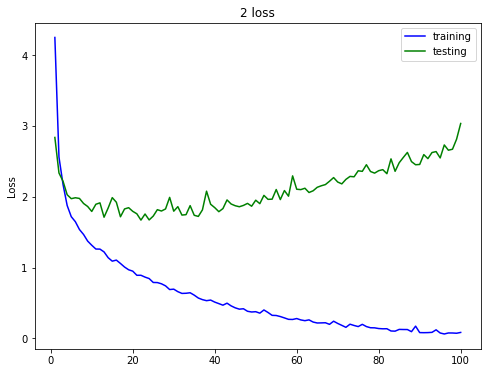

3: 
Training accuracy :  0.9869999885559082
Testing accuracy :  0.5443333387374878


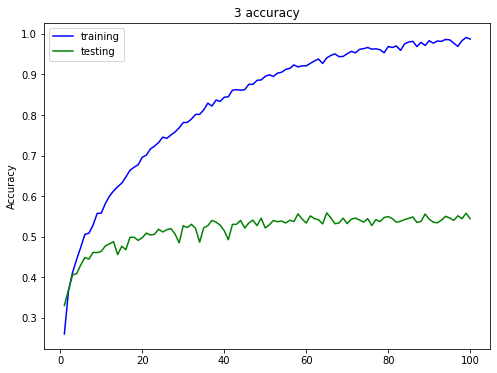

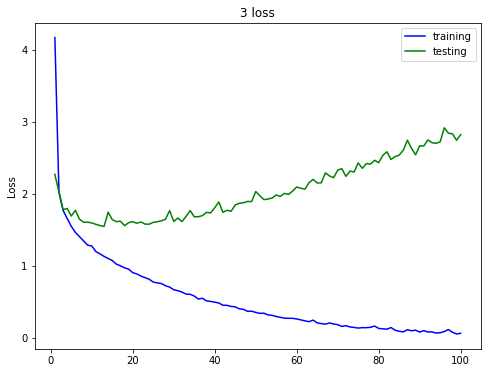

4: 
Training accuracy :  0.9921428561210632
Testing accuracy :  0.5506666898727417


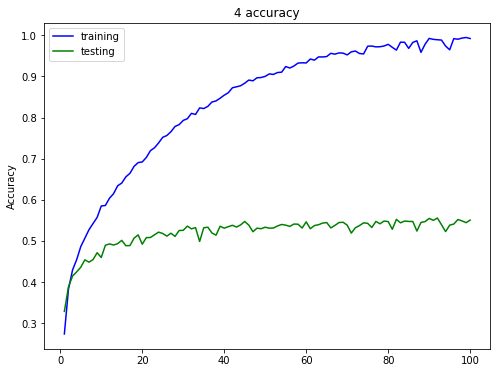

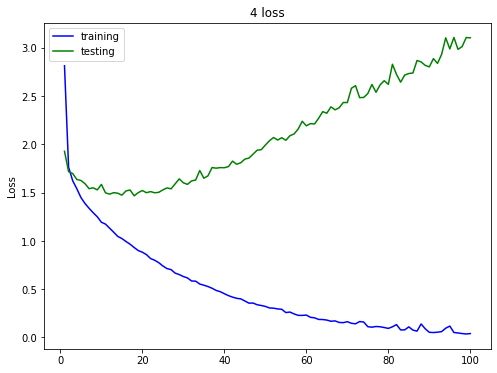

In [175]:
metrics(history_list, hidden_layer_list)

In conclusion, increasing or decreasing the number of layers have no effect on variance. This is because we have too many neurons per layer. So we take 3 layers and reduce the number of neurons.

## Finding required number of neurons
activation = softmax <br>
learning rate = 0.0001 <br>
number of layers = 3 <br>
activation of output layer is fixed to be softmax
epochs = 100 <br>
drop out probability = 0.3 <br>
alpha = 0.001

In [180]:
hidden_layer_list_neurons = [[512,256,128], [256,128,64], [180,90,30],[128,64,32]]
history_list = []
for i in range(len(hidden_layer_list_neurons)):
  history = implements(x_train, y_train, x_test,y_test, activation_h="softplus", learning_rate=0.0001, n_hidden=3, n_neurons=hidden_layer_list_neurons[i])
  history_list.append(history.history)

[512, 256, 128]: 
Training accuracy :  0.9984285831451416
Testing accuracy :  0.5636666417121887


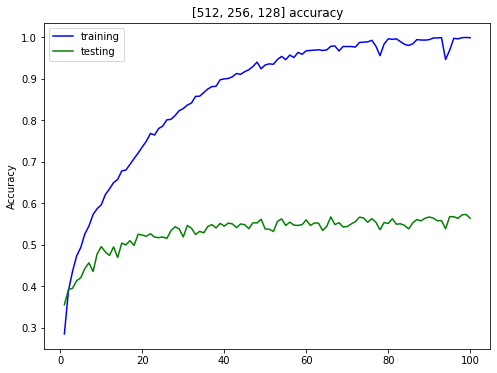

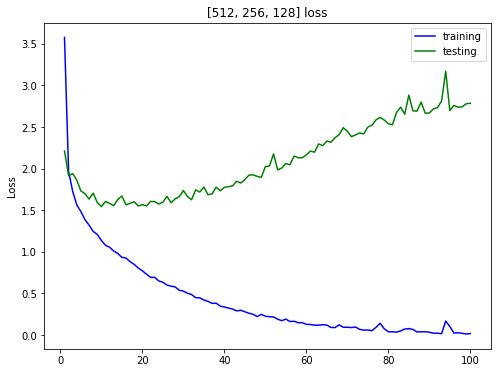

[256, 128, 64]: 
Training accuracy :  0.915142834186554
Testing accuracy :  0.5149999856948853


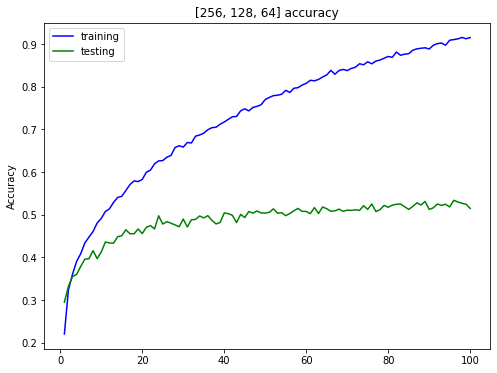

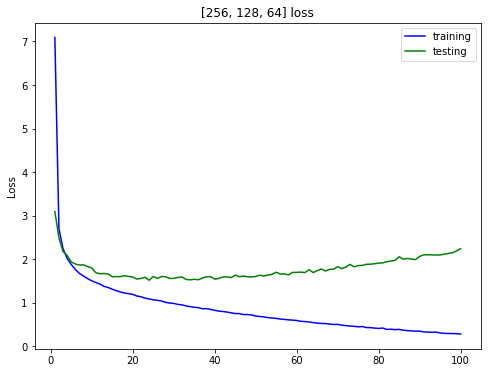

[180, 90, 30]: 
Training accuracy :  0.7991428375244141
Testing accuracy :  0.503000020980835


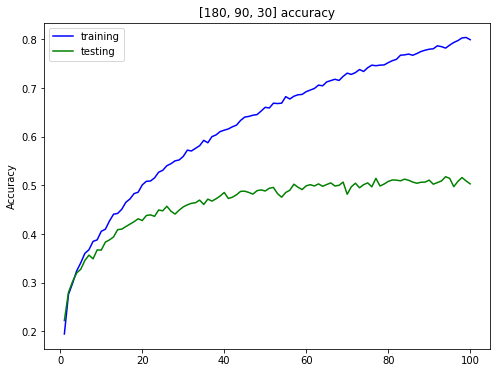

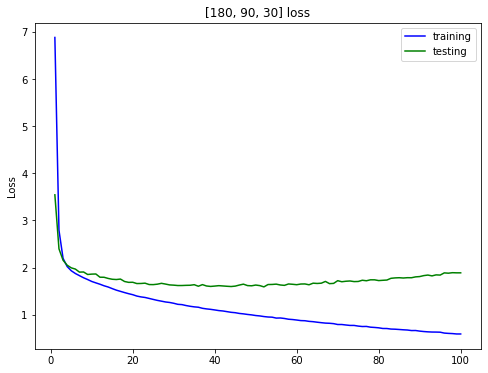

[128, 64, 32]: 
Training accuracy :  0.6991428732872009
Testing accuracy :  0.49000000953674316


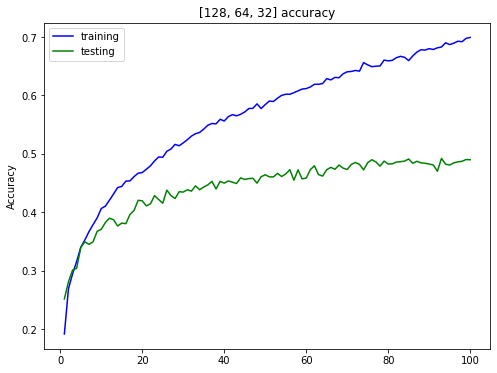

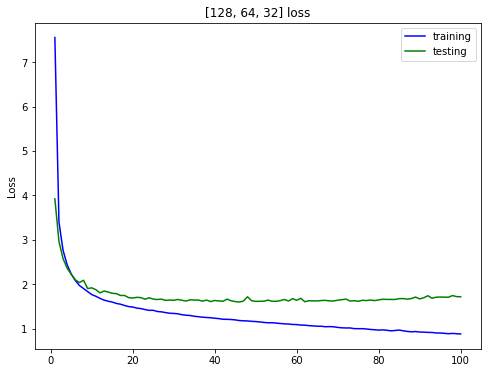

In [181]:
metrics(history_list, hidden_layer_list_neurons)

Now for the same neuron set, we apply regularization and neuron dropout to find any change in the variance for high number of neurons with reducing the number of neurons

In [182]:
history_list = []
for i in range(len(hidden_layer_list_neurons)): 
  history = implements(x_train, y_train, x_test,y_test, activation_h="softplus", learning_rate=0.0001, n_hidden=3, n_neurons=hidden_layer_list_neurons[i], dropout=True, regularize=True)
  history_list.append(history.history)

[512, 256, 128]: 
Training accuracy :  0.6759999990463257
Testing accuracy :  0.5830000042915344


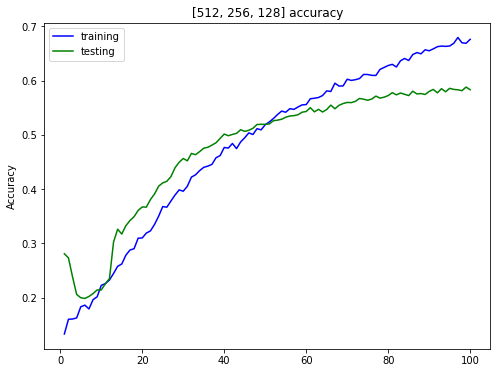

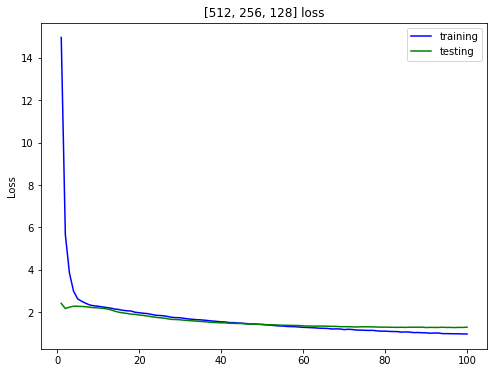

[256, 128, 64]: 
Training accuracy :  0.5278571248054504
Testing accuracy :  0.5189999938011169


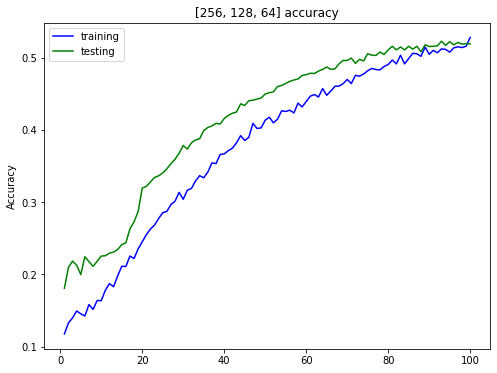

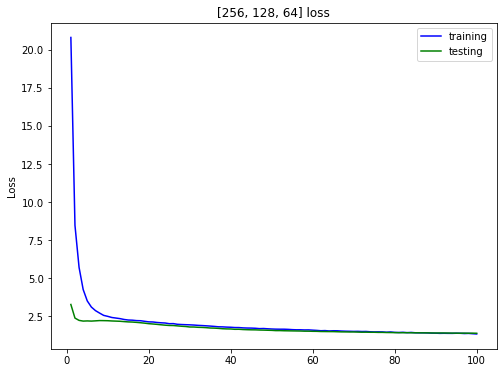

[180, 90, 30]: 
Training accuracy :  0.43642857670783997
Testing accuracy :  0.46299999952316284


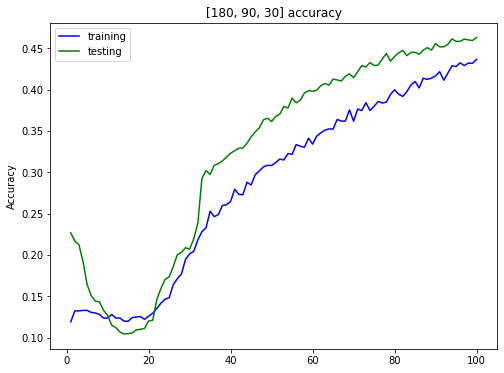

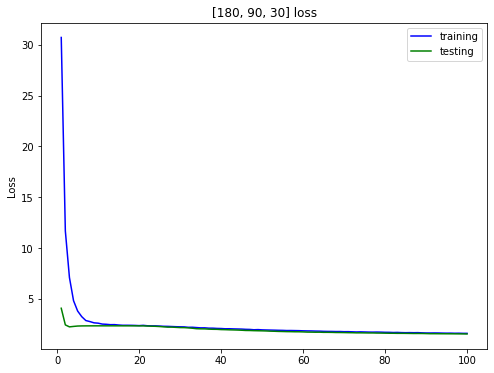

[128, 64, 32]: 
Training accuracy :  0.386428564786911
Testing accuracy :  0.4203333258628845


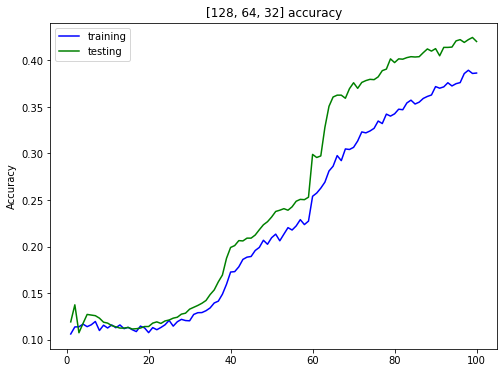

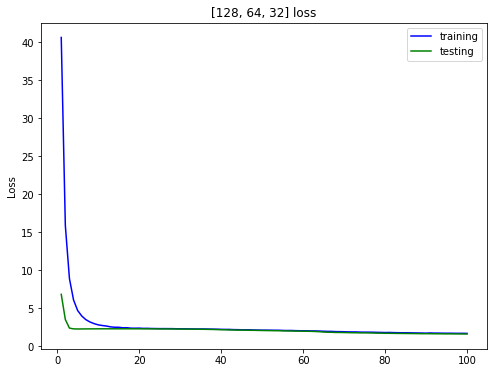

In [183]:
metrics(history_list, hidden_layer_list_neurons)

So in conclusion, if we have high number of neurons per layer, then applying regularization techniques will increase the accuracy and decrease the variance overall. If we do not apply any regularization techniques then we can have moderate number of neurons to have a decent accuracy on training and testing set with low accuracy. <br>

#### For our purposes, we select high number of neurons per layer with regularization

## Cross-checking the metrics with the common activation relu

In [188]:
history_list = [] 
history = implements(x_train, y_train, x_test,y_test, activation_h="softplus", learning_rate=0.0001, n_hidden=3, n_neurons=[512,256,128], dropout=True, regularize=True, epochs=100)
history_list.append(history.history)
history = implements(x_train, y_train, x_test,y_test, activation_h="relu", learning_rate=0.0001, n_hidden=3, n_neurons=[512,256,128], dropout=True, regularize=True, epochs=100)
history_list.append(history.history)

softplus: 
Training accuracy :  0.7720000147819519
Testing accuracy :  0.6066666841506958


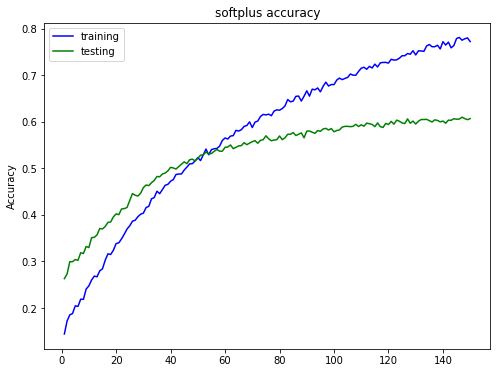

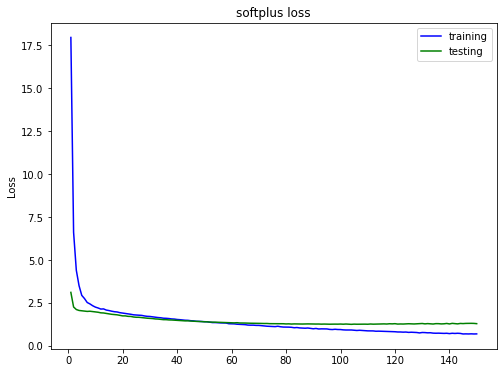

relu: 
Training accuracy :  0.7295714020729065
Testing accuracy :  0.5863333344459534


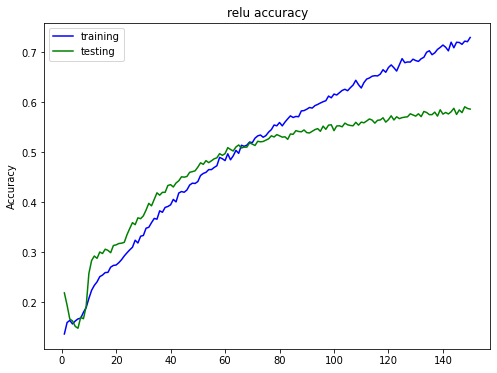

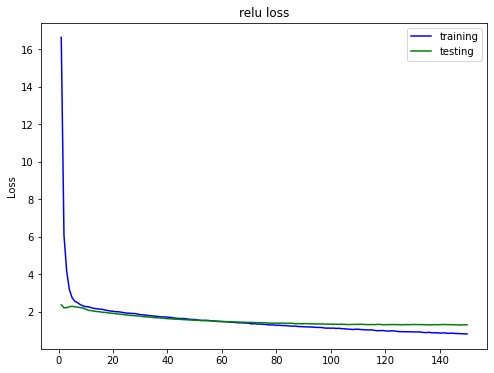

In [189]:
metrics(history_list, ["softplus", "relu"])

#### From all our analysis and extra experimentation we conclude our model with following metrics: <br>
#### activation : softmax <br>
#### learning rate : 0.0001 <br>
#### number of hidden layers = 3 <br>
#### number of neurons in each layer = [512,256,128] <br>
#### epochs = 100 <br>
#### regularization and dropout true 


In [208]:
from sklearn.metrics import confusion_matrix, precision_score, roc_curve, roc_auc_score, recall_score

def implement_predict(x,y,xt,yt,activation_h = "softplus", activation_o = "softmax",n_hidden = 3, n_neurons = [512, 256, 128], 
               learning_rate = 0.0001, epochs = 100, batch_size = 32, regularize = True, alpha = 0.001, dropout = True, dropout_prob = 0.3):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(x.shape[1], x.shape[2])))
  for i in range(n_hidden):
    if regularize:
      model.add(keras.layers.Dense(n_neurons[i], activation=activation_h, kernel_regularizer=keras.regularizers.l2(0.0001)))
    else:
      model.add(keras.layers.Dense(n_neurons[i], activation=activation_h))

    if dropout:
      model.add(keras.layers.Dropout(0.3))

  model.add(keras.layers.Dense(10, activation=activation_o))
  optimiser = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.fit(x, y, validation_data=(xt, yt), batch_size=batch_size, epochs=epochs, verbose=0)
  return model.predict(xt)

In [194]:
y_pred = implement_predict(x_train, y_train, x_test,y_test)

[[205   1   0   5   3  11  20  11  21   7]
 [  1 204  22   4  22  21  16   4   9  11]
 [  1  16 250   0  12   1   2   5   8   1]
 [  1   1   0 254   6  34   0   0   0   2]
 [ 25  39  26   3 116  27  21  25  13  26]
 [  3  17   0  17  10 215  12   5   3   9]
 [ 22  28   6   8  14  21 139  23  28  21]
 [ 26  22  19   3  37  18  40 113  26   9]
 [ 36  14  19   4  16  13  40  27 105   5]
 [ 10  32   7   9  16  53  20  13   8 126]]

Precision on the model :	 0.5679788104174975
Recall on the model : 		 0.5756666666666667
F1score on the model : 		 0.5717968987451817


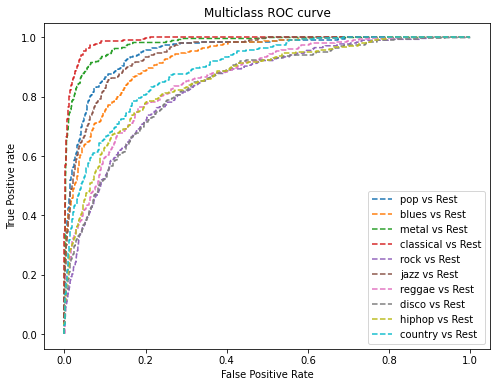

In [221]:
y_result = np.argmax(y_pred,axis = 1)
matrix = confusion_matrix(y_test, y_result)  
precision = precision_score(y_test, y_result, average = "weighted")
recall = recall_score(y_test, y_result, average = "weighted")
f1score = 2*precision*recall/(precision + recall)

print(matrix)
print("")
print("Precision on the model :\t",precision)
print("Recall on the model : \t\t",recall)
print("F1score on the model : \t\t",f1score)

fpr = {}
tpr = {}
thresh ={}
for i in range(len(genre_list)):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred[:,i], pos_label=i)

# Plot the ROC chart
for i in range(len(genre_list)):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=genre_list[i] + ' vs Rest')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()